**Name:** Luk Wing San (20193803), Gao Shenlai(20256746), Cheung Tin Yan (20197342)

**Math 4432: Project 3 Report Summary**

**Problem chosen:** Nexperia Predictive Maintenance Contest (Mini)

**Question proposed:** Which features may be more important than others for predicting failure? Which model may perform better?

**Goal:** Build a good prediction model with high area-under-curve (it is evaluated by Kaggle)

**Contributions:** Luk Wing San 1/3, Gao Shenlai 1/3, Timothy Cheung 1/3

**Conclusion:**
We found that among all of the features, 136222210 and 136224578 may be the most important two and we get our best result around 0.515 through dense neural net and lstm neural net. We rank 2 among 4 teams in Nexperia Predictive Maintenance Contest (Mini).

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import datetime, time
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense, Flatten
from keras.models import model_from_json
from sklearn.metrics import roc_curve, auc

from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn.cross_validation import KFold
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Simple Helpful Functions and a Little Preprocessing for Neat Data

Basically, we set the Label to be 0 or 1 and merge the top three header rows to make our dataset look more neat. 

Other helpful functions are designed to help process or evaluate result. 

In [2]:
def getData(path, mode='train'):
    df = pd.read_csv(path, dtype = str, header=[0,1], skiprows = [2])
#     print(df.columns.values)
    df.columns = ['_'+'_'.join(tup).rstrip('_')+'_' for tup in df.columns.values]
    df = df.rename(columns = {'_Unnamed: 0_level_0_Unnamed: 0_level_1_':'Machine', '_Unnamed: 1_level_0_Unnamed: 1_level_1_':'Date', '_Label_Unnamed: 83_level_1_': 'Label'})
    if mode == 'train':
        # some rows in training data doesn't have the label so we drop them
        df = df.dropna(subset=['Label'])
        label = [1 if l == 'True' else 0 for l in df['Label']]
        df['Label'] = label
    df = df.fillna(0)
    return df
def get_roc_and_area(predictions_test, outcome_test):
    fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
def writecsv (ypred, data, file_name):
    date=data['Date'].copy()
    date=[datetime.datetime.strptime(d, "%d/%m/%Y").date().strftime('%d/%m/%Y') for d in date]
    submission = pd.DataFrame({
        "id": data["Machine"]+'-'+date,
        'label': ypred
    })
    submission.to_csv(file_name, sep=',', index=False)
def measureResult (ypred, ytest, Logging=True):
    mse = np.mean((ytest - ypred)**2)
    accuracy = np.mean(ytest == ypred)
    Survived_mean=np.mean(ytest)
    uss=np.mean((ytest - ypred)**2)
    dss=np.mean((ytest - Survived_mean)**2)
    r2 = 1-uss/dss
    if Logging:
        print('mse ', mse)
        print('accuracy', accuracy)
        print('R2', r2)
    return mse, accuracy, r2

### a Little Exploration

In [3]:
train = getData('data/Training freq 1D OW 2 PW 1.csv')
train.head()

,Machine,Date,_1_count_,_1_vMean_,_1_vStd_,_136088194_count_,_136088194_vMean_,_136088194_vStd_,_136088202_count_,_136088202_vMean_,...,_136676698_count_,_136676698_vMean_,_136676698_vStd_,_136676714_count_,_136676714_vMean_,_136676714_vStd_,_136676754_count_,_136676754_vMean_,_136676754_vStd_,Label
0,M040_A1,2015-05-31,11.0,7850.549028900001,9407.843666684488,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M040_A1,2015-06-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M040_A1,2015-06-02,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,M040_A1,2015-06-03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M040_A1,2015-06-04,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here we want to know the count status in the dataset. 

(1) for each different label, we sum the count feature for each of them. 
(2) for each different label, we count how many count features are bigger than 0 (that error occurs) for each of the count feature
(3) similar to (1) but we also do it for every machine

We found that for most of the features, the ratio of the statistics of positive label over the statistics of negative label is around 0.1 without much vary, but some of them have significantly higher or lower ratio. And we also noticed that some of the features rarely appear for most of the machine.

To find the most important feature and reduce the dimensionality of the dataset, we use random forest as the analytic helper. 

In [4]:
def explore(data):
    # total count for each of the count feature for different label
    countDict1 = {}
    countDict0 = {}
    for col in data.columns:
        if col.find('count') != -1:
            m = data[data['Label']==1][col]
            mFloat = [float(v) for v in m.values]
            countDict1[col] = np.sum(mFloat)
            m = data[data['Label']==0][col]
            mFloat = [float(v) for v in m.values]
            countDict0[col] = np.sum(mFloat)
    for key in countDict1:
        # the count feature, count for label 0, count for label 1, ratio
        print(key, countDict1[key], countDict0[key], countDict1[key]/countDict0[key], end='\n')
        
    appeared = {}
    for col in data.columns:
        if col.find('count') != -1:
            m = data[data['Label']==1][col]
            mFloat = [float(v) for v in m.values]
            k = []
            for v in mFloat:
                k.append(v > 0)

            m = data[data['Label']==0][col]
            mFloat = [float(v) for v in m.values]
            k2 = []
            for v in mFloat:
                k2.append(v > 0)
            # for each count feature, how many of it is larger than 0 for different labels
            appeared[col] = [np.sum(k), np.sum(k2), np.sum(k)/np.sum(k2)]
    for key in appeared:
        print(key, appeared[key])

    # total count for each of the count feature for different label for each machine
    machines = np.unique(data['Machine'])
    for machine in machines:
        machineRecords = data[data['Machine']==machine]

        days = machineRecords['Machine'].count()
        
        countDict1 = {}
        countDict0 = {}
        for col in machineRecords.columns:
            if col.find('count') != -1:
                m = machineRecords[machineRecords['Label']==1][col]
                mFloat = [float(v) for v in m.values]
                countDict1[col] = np.sum(mFloat)
                m = machineRecords[machineRecords['Label']==0][col]
                mFloat = [float(v) for v in m.values]
                countDict0[col] = np.sum(mFloat)

        print(machine)
        print(days, ' days')
        for key in countDict1:
            print(key, countDict1[key], countDict0[key], countDict1[key]/countDict0[key], end='\n')
explore(train)

_1_count_ 3558.0 28644.0 0.12421449518223712
_136088194_count_ 1558.0 14151.0 0.11009822627376158
_136088202_count_ 518.0 3996.0 0.12962962962962962
_136088394_count_ 507.0 4600.0 0.11021739130434782
_136088802_count_ 1121.0 6675.0 0.16794007490636703
_136089546_count_ 890.0 6701.0 0.13281599761229668
_136110468_count_ 1120491.0 12512552.0 0.08954935811655368
_136216674_count_ 429.0 3227.0 0.13294081189959714
_136222202_count_ 10667.0 108901.0 0.09795135030899624
_136222210_count_ 5108.0 52834.0 0.09668016807358898
_136222234_count_ 281.0 2454.0 0.11450692746536267
_136222250_count_ 1112.0 9605.0 0.11577303487766788
_136222882_count_ 732.0 7383.0 0.09914668833807395
_136223186_count_ 1133.0 11733.0 0.09656524333077644
_136224578_count_ 49786.0 424443.0 0.1172972578178931
_136224586_count_ 33871.0 341473.0 0.09919085842804555
_136224978_count_ 1074.0 11599.0 0.09259418915423744
_136225010_count_ 99849.0 1431048.0 0.06977334093615309
_136675426_count_ 474.0 7841.0 0.060451473026399694
_1

_136676666_count_ 0.0 0.0 nan
_136676682_count_ 0.0 0.0 nan
_136676698_count_ 0.0 0.0 nan
_136676714_count_ 0.0 0.0 nan
_136676754_count_ 0.0 0.0 nan
M042_A4
998  days
_1_count_ 154.0 1732.0 0.08891454965357967
_136088194_count_ 192.0 2018.0 0.09514370664023786
_136088202_count_ 0.0 4.0 0.0
_136088394_count_ 7.0 47.0 0.14893617021276595
_136088802_count_ 7.0 97.0 0.07216494845360824
_136089546_count_ 42.0 456.0 0.09210526315789473
_136110468_count_ 106726.0 1178726.0 0.09054351901968735
_136216674_count_ 29.0 45.0 0.6444444444444445
_136222202_count_ 841.0 9762.0 0.08615037902069247
_136222210_count_ 378.0 4454.0 0.08486753480017961
_136222234_count_ 26.0 194.0 0.13402061855670103
_136222250_count_ 18.0 134.0 0.13432835820895522
_136222882_count_ 16.0 230.0 0.06956521739130435
_136223186_count_ 53.0 297.0 0.17845117845117844
_136224578_count_ 3985.0 42768.0 0.0931771417882529
_136224586_count_ 3161.0 34748.0 0.09096926441809601
_136224978_count_ 8.0 160.0 0.05
_136225010_count_ 27452.0

#### here we build a random forest model for all of the features

In [5]:
# build a random forest model
def RandomForestModel (train_X, train_y, num_estimator):
    randomforest = RandomForestClassifier(n_estimators=num_estimator)
    randomforest.fit(train_X, train_y)
    return randomforest
def processData (data):
    newData = pd.DataFrame()
    for col in data.columns:
        if col not in ['Label','Machine','Date']:
            newData[col+'0_']=data[col]
            newData[col+'1_']=data[col].copy().shift(1)
            newData[col+'2_']=data[col].copy().shift(2)
    newData = newData.fillna(0)

    return newData

597 8000 0.074625
270 3707 0.07283517669274346
0.0285 0.9715 0.5872921272579296


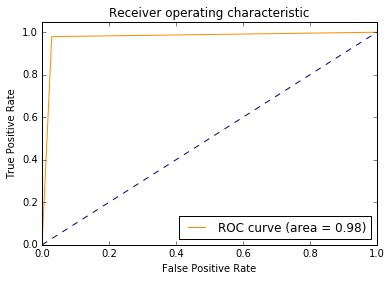

0.0566495818721338 0.9433504181278662 0.16112242588821013


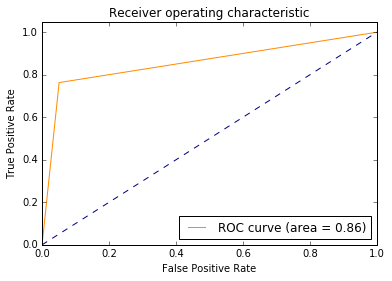

0.05817032544631417 0.9418296745536858 0.15529400022631534


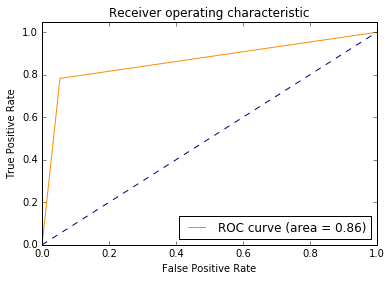

In [6]:
train = getData('data/Training freq 1D OW 2 PW 1.csv')
verification = getData('data/Verification freq 1D OW 2 PW 1.csv', 'test')
ptrain = processData(train)
pverification = processData(verification)
                
dataX = ptrain.copy()
datay = train['Label'].copy()

train_index = np.random.randint(len(dataX), size=8000)
test_index = np.random.randint(len(dataX), size=len(dataX) - 8000)

train_X = dataX.values[train_index]
train_y = datay.values[train_index]
test_X = dataX.values[test_index]
test_y = datay.values[test_index]

print(np.sum(train_y), len(train_y), np.sum(train_y)/len(train_y))
print(np.sum(test_y), len(test_y), np.sum(test_y)/len(test_y))

random_forest = RandomForestModel(train_X, train_y, 2)
y_pred = random_forest.predict(train_X)
mse, acc, r2 = measureResult(y_pred, train_y, False)
print(mse, acc, r2)
get_roc_and_area(y_pred, train_y)

y_pred = random_forest.predict(test_X)
mse, acc, r2 = measureResult(y_pred, test_y, False)
print(mse, acc, r2)
get_roc_and_area(y_pred, test_y)

y_pred = random_forest.predict(dataX.values)
mse, acc, r2 = measureResult(y_pred, datay.values, False)
print(mse, acc, r2)
get_roc_and_area(y_pred, datay.values)

243 243


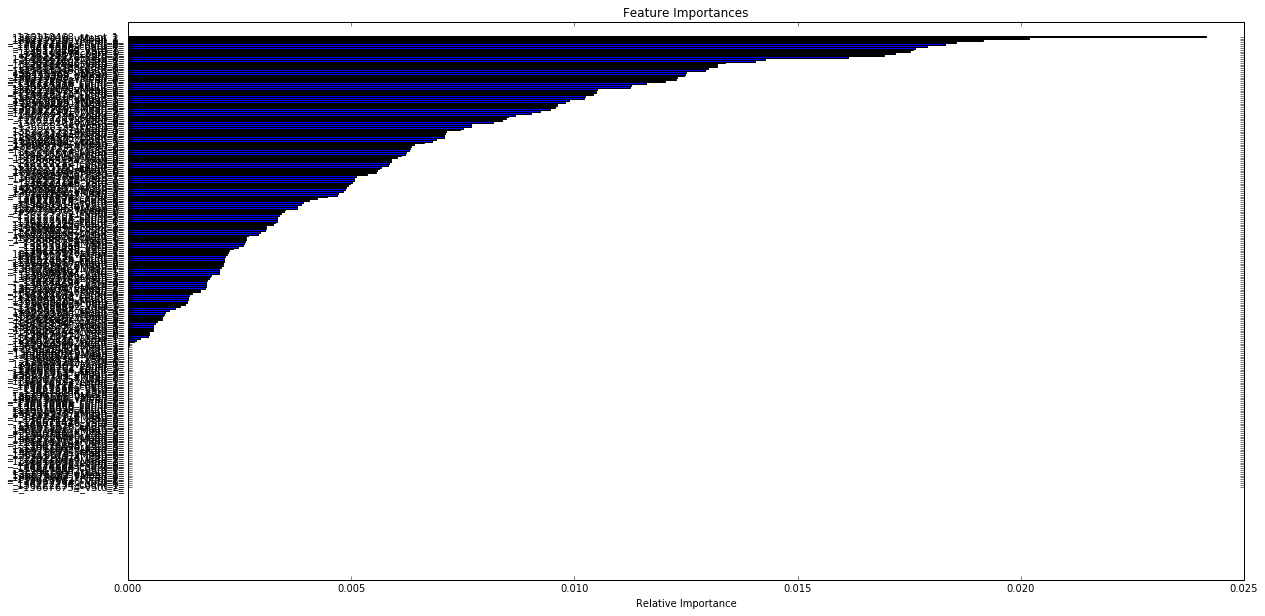

Index(['_136224586_vMean_1_', '_136110468_vStd_0_', '_136224578_count_0_',
       '_136224586_vStd_2_', '_136224586_vMean_2_', '_136224586_vStd_1_',
       '_136222202_vStd_2_', '_136224586_vMean_0_', '_136224578_vStd_2_',
       '_136224578_vStd_1_', '_136110468_count_0_', '_136110468_vStd_1_',
       '_136222202_vStd_1_', '_136110468_vStd_2_', '_136224586_count_0_',
       '_136224586_count_2_', '_136222202_count_0_', '_136222210_vMean_1_',
       '_136225010_vMean_2_', '_136110468_count_1_'],
      dtype='object')


In [7]:
features_names = dataX.columns
importances = random_forest.feature_importances_
print(len(importances), len(features_names))
indices = np.argsort(importances)
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features_names[indices])
plt.xlabel('Relative Importance')
plt.show()
print(features_names[indices[len(indices)-20:len(indices)]])

#### based on previous result, we select some of the features and rebuild a random forest model

In [8]:
def processData (data):
    newData = pd.DataFrame()
    for col in data.columns:
        if col not in ['Label','Machine','Date'] and col.find('count') != -1:
            newData[col+'0_']=data[col]
            newData[col+'1_']=data[col].copy().shift(1)
            newData[col+'2_']=data[col].copy().shift(2)
    newData = newData.fillna(0)
    arr=np.sum(newData.values.astype(float), axis=1)
    newData['totalCount'] = arr

    columns = ['_136222210_count_2_',
           '_136222202_count_1_', '_136222202_count_2_', '_136222210_count_0_',
           '_136225010_count_2_', '_136225010_count_1_', '_136224578_count_0_',
           '_136225010_count_0_', '_136222202_count_0_',
            '_136224578_count_1_',
           '_136224578_count_2_',
           '_136110468_count_0_', '_136110468_count_1_', '_136110468_count_2_',
            '_136224586_count_2_', '_136224586_count_0_', '_136224586_count_1_',
            'totalCount']
    # 136222210 136222202 136225010 136224578 136224586 136110468
    newData = newData[columns]
    
    newData['_136222210_mts_'] = data['_136222210_vMean_'].values.astype(float) * data['_136222210_vStd_'].values.astype(float)
    newData['_136222202_mts_'] = data['_136222202_vMean_'].values.astype(float) * data['_136222202_vStd_'].values.astype(float)
    newData['_136225010_mts_'] = data['_136225010_vMean_'].values.astype(float) * data['_136225010_vStd_'].values.astype(float)
    newData['_136224578_mts_'] = data['_136224578_vMean_'].values.astype(float) * data['_136224578_vStd_'].values.astype(float)
    newData['_136224586_mts_'] = data['_136224586_vMean_'].values.astype(float) * data['_136224586_vStd_'].values.astype(float)
    newData['_136110468_mts_'] = data['_136110468_vMean_'].values.astype(float) * data['_136110468_vStd_'].values.astype(float)
  
    return newData

590 8000 0.07375
271 3707 0.07310493660642028
0.025625 0.974375 0.6248770557423547


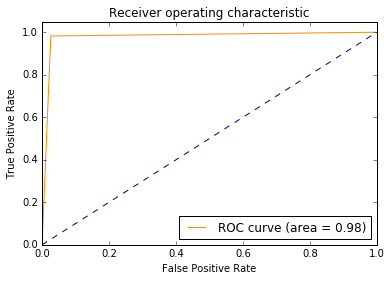

0.05880766118154842 0.9411923388184515 0.13212608843201357


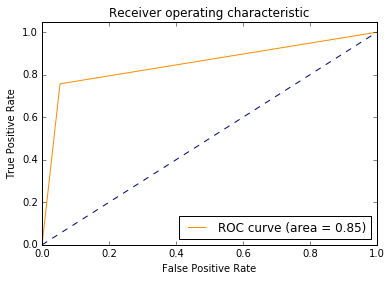

0.05817032544631417 0.9418296745536858 0.15529400022631534


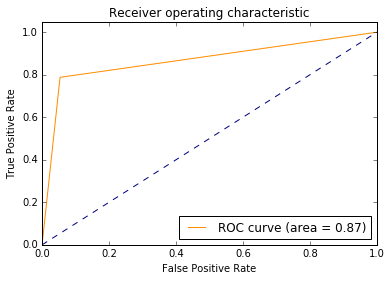

In [9]:
train = getData('data/Training freq 1D OW 2 PW 1.csv')
verification = getData('data/Verification freq 1D OW 2 PW 1.csv', 'test')
ptrain = processData(train)
pverification = processData(verification)
                
dataX = ptrain.copy()
datay = train['Label'].copy()

train_index = np.random.randint(len(dataX), size=8000)
test_index = np.random.randint(len(dataX), size=len(dataX) - 8000)

train_X = dataX.values[train_index]
train_y = datay.values[train_index]
test_X = dataX.values[test_index]
test_y = datay.values[test_index]

print(np.sum(train_y), len(train_y), np.sum(train_y)/len(train_y))
print(np.sum(test_y), len(test_y), np.sum(test_y)/len(test_y))

random_forest = RandomForestModel(train_X, train_y, 2)
y_pred = random_forest.predict(train_X)
mse, acc, r2 = measureResult(y_pred, train_y, False)
print(mse, acc, r2)
get_roc_and_area(y_pred, train_y)

y_pred = random_forest.predict(test_X)
mse, acc, r2 = measureResult(y_pred, test_y, False)
print(mse, acc, r2)
get_roc_and_area(y_pred, test_y)

y_pred = random_forest.predict(dataX.values)
mse, acc, r2 = measureResult(y_pred, datay.values, False)
print(mse, acc, r2)
get_roc_and_area(y_pred, datay.values)

y_pred = random_forest.predict(pverification)
writecsv(y_pred, verification, 'report-random-forest.csv')

24 24


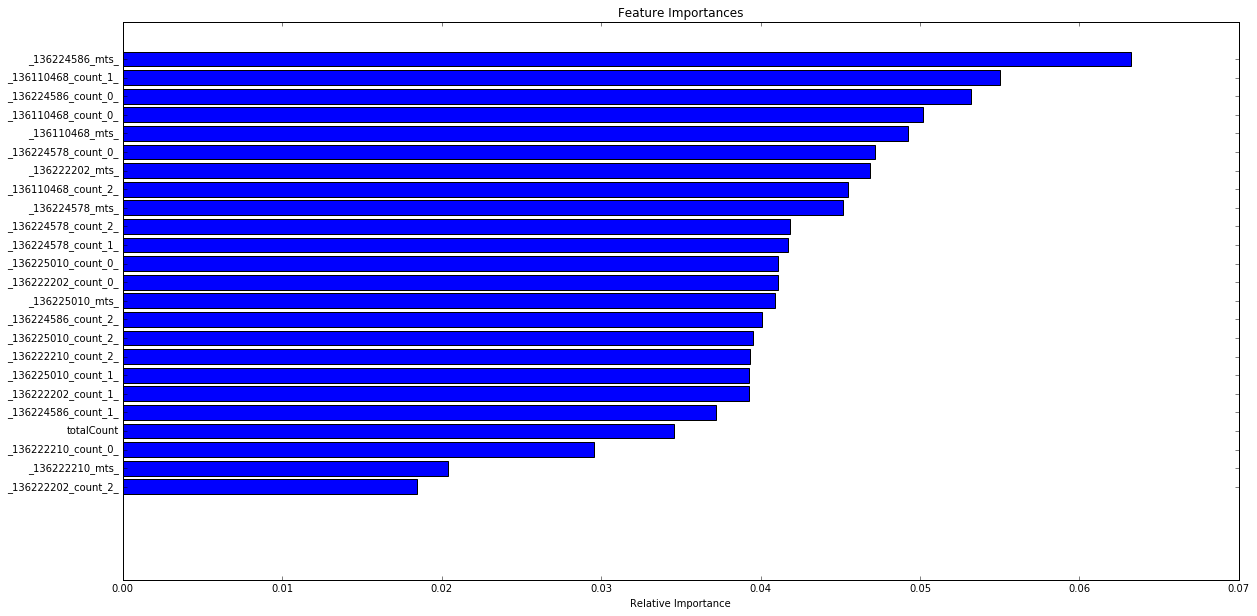

Index(['_136224586_count_1_', '_136222202_count_1_', '_136225010_count_1_',
       '_136222210_count_2_', '_136225010_count_2_', '_136224586_count_2_',
       '_136225010_mts_', '_136222202_count_0_', '_136225010_count_0_',
       '_136224578_count_1_', '_136224578_count_2_', '_136224578_mts_',
       '_136110468_count_2_', '_136222202_mts_', '_136224578_count_0_',
       '_136110468_mts_', '_136110468_count_0_', '_136224586_count_0_',
       '_136110468_count_1_', '_136224586_mts_'],
      dtype='object')


In [10]:
features_names = dataX.columns
importances = random_forest.feature_importances_
print(len(importances), len(features_names))
indices = np.argsort(importances)
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features_names[indices])
plt.xlabel('Relative Importance')
plt.show()
print(features_names[indices[len(indices)-20:len(indices)]])

We found that with only the selected features (136222210 136222202 136225010 136224578 136224586 136110468) in the dataset, the area under curve doesn't decrease much. So we may regard these features as the most representative and significant one. 

### Logitstic Regression with Label Weights

We first define our confusion matrix function here. It will return true positive rate of our testing set.

In [11]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)

    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.4f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.4f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.4f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.4f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.4f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    plt.tight_layout()
    plt.show()
    return (tp / (tp+fn+0.))
def get_roc_and_area(predictions_test, outcome_test):
    fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    




Since there are many samples with label of "False" indicating those machines function normally with very few samples labelled as "True" (which means those machines are facing failure), there is serious unbalancing between different classes(True vs False) of samples. Therefore, we define a function of stratisfied sampling here to ensure the ratio between False label sample and True label sample is the same in both testing set and training set when training our logistic regression model. This can prevent the case that all our training set samples are only having labels with "False", which may seriously affect the prediction ability of our model. After that, we conduct k-fold cross validation with k=10 while training our model in logistic regression.

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight


def train_and_calibrate_cv(model, X_tr, y_tr,cv):
    from sklearn.model_selection import StratifiedKFold
    y_pred_xval = np.zeros(len(y_tr))
    skf = StratifiedKFold(cv,shuffle=True)
    total=0;
    i = 0;
    #Maxmodel;
    MaxTruePositive=0;
    for train, test in skf.split(X_tr,y_tr):
        average=0
        i = i+1
        print("training fold {} of {}".format(i, cv))
        X_train_xval = np.array(X_tr)[train,:]
        X_test_xval = np.array(X_tr)[test,:]
        y_train_xval = np.array(y_tr)[train]
        y_test_xval=np.array(y_tr)[test]
        # We could also copy the model first and then fit it
       # model_copy = model
       # class_Weight = class_weight.compute_class_weight('balanced',np.unique(y_train_xval),y_train_xval)
        model.fit(X_train_xval,y_train_xval)
        #confusion_matrix(y_true, y_pred)
        C = confusion_matrix(y_test_xval, model.predict(X_test_xval))
        #np.set_printoptions(precision=2)
        #plt.figure()
        #plot_confusion_matrix(C, classes= y_tr,title='Confusion matrix, without normalization')
        #plt.show()
        average=show_confusion_matrix(C, ['No Failure', 'Failure'])
        get_roc_and_area(model.predict(X_test_xval), y_test_xval)
        if (average>MaxTruePositive):
            MaxTruePositive=average
            Maxmodel=model
        total = average + total
        #print(test)
        #print(train)
        #y_pred_xval[test]=model.predict_proba(X_test_xval)[:,1]
    print("average true positive rate:" ,total/cv)
    print("Maximum true positive rate:",MaxTruePositive)
    print("training full model")
    #model_copy = model
    #model.fit(X_tr,y_tr)
    #print("calibrating function")
    #calib_func = prob_calibration_function(y_tr, y_pred_xval)
    #test1
    #C = confusion_matrix(y_test_xval, Maxmodel.predict(X_test_xval))
    #show_confusion_matrix(C, ['Not Trend', 'Trend'])
    #get_roc_and_area(Maxmodel.predict(X_test_xval), y_test_xval)
    #print(X_test_xval)
    #print(model.predict(X_test_xval))
    #print(y_test_xval)
    return Maxmodel,test, train
    
#logisticRegr = LogisticRegression() 
#model, test, train = train_and_calibrate_cv(logisticRegr,df[training_features],df[target],10)
#for i in test:
#    model.predict(df.loc(i))
#print(model.predict(X_test_xval))
#print(y_test_xval)
#df['y_hats'] = y_hats.reset_index()[target]

We conudct preprocessing for our data here. Two more shifts are added on each row to increase the time dependency between data for easier training. We also make a new column "totalCount" in our dataset which is a sum of counts. We include it because we find that it is an important feature for training from graphs we plotted previously in this report. We fill all missing data with 0.

In [13]:
def processNew_Data (data):
    newData = pd.DataFrame()
    newData['Machine']=data['Machine']
    newData['Date']=data['Date']
    for col in data.columns:
        if col not in ['Label','Machine','Date']:
            newData[col+'0_']=data[col]
            newData[col+'1_']=data[col].copy().shift(1)
            newData[col+'2_']=data[col].copy().shift(2)
        
    newData = newData.fillna(0)
    arr=np.sum(newData.values[:,2:].astype(float), axis=1)
    newData['totalCount'] = arr
    newData['Label']=data['Label']
    
    return newData
newtrain = processNew_Data(train)
newtrain.head()


,Machine,Date,_1_count_0_,_1_count_1_,_1_count_2_,_1_vMean_0_,_1_vMean_1_,_1_vMean_2_,_1_vStd_0_,_1_vStd_1_,...,_136676754_count_1_,_136676754_count_2_,_136676754_vMean_0_,_136676754_vMean_1_,_136676754_vMean_2_,_136676754_vStd_0_,_136676754_vStd_1_,_136676754_vStd_2_,totalCount,Label
0,M040_A1,2015-05-31,11.0,0,0,7850.549028900001,0,0,9407.843666684488,0,...,0,0,0,0,0,0,0,0,152174.366099,0
1,M040_A1,2015-06-01,0,11.0,0,0,7850.549028900001,0,0,9407.843666684488,...,0,0,0,0,0,0,0,0,152174.366099,0
2,M040_A1,2015-06-02,0,0,11.0,0,0,7850.549028900001,0,0,...,0,0,0,0,0,0,0,0,152174.366099,1
3,M040_A1,2015-06-03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1138.775145,0
4,M040_A1,2015-06-04,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,59929.270101,0


From the statistics below we can see that there are a large number of samples with label = 0, which means "False". This proves the unbalancing of classes of samples. 

In [14]:
newtrain['Label'].describe()

count    11707.000000
mean         0.074400
std          0.262432
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Label, dtype: float64

Another statistics below showing the exact counts of number of unbalancing of label samples. "0" ("False") labelled sample are 10 times more than "1" ("True") labelled sample. 

In [15]:
newtrain.groupby('Label').size()

Label
0    10836
1      871
dtype: int64

In [16]:
list(newtrain)

['Machine',
 'Date',
 '_1_count_0_',
 '_1_count_1_',
 '_1_count_2_',
 '_1_vMean_0_',
 '_1_vMean_1_',
 '_1_vMean_2_',
 '_1_vStd_0_',
 '_1_vStd_1_',
 '_1_vStd_2_',
 '_136088194_count_0_',
 '_136088194_count_1_',
 '_136088194_count_2_',
 '_136088194_vMean_0_',
 '_136088194_vMean_1_',
 '_136088194_vMean_2_',
 '_136088194_vStd_0_',
 '_136088194_vStd_1_',
 '_136088194_vStd_2_',
 '_136088202_count_0_',
 '_136088202_count_1_',
 '_136088202_count_2_',
 '_136088202_vMean_0_',
 '_136088202_vMean_1_',
 '_136088202_vMean_2_',
 '_136088202_vStd_0_',
 '_136088202_vStd_1_',
 '_136088202_vStd_2_',
 '_136088394_count_0_',
 '_136088394_count_1_',
 '_136088394_count_2_',
 '_136088394_vMean_0_',
 '_136088394_vMean_1_',
 '_136088394_vMean_2_',
 '_136088394_vStd_0_',
 '_136088394_vStd_1_',
 '_136088394_vStd_2_',
 '_136088802_count_0_',
 '_136088802_count_1_',
 '_136088802_count_2_',
 '_136088802_vMean_0_',
 '_136088802_vMean_1_',
 '_136088802_vMean_2_',
 '_136088802_vStd_0_',
 '_136088802_vStd_1_',
 '_136088

We then conduct logistic regression. We add weighting on samples with label "True" 10 times heavier than the "False" label class samples based on the ratio of counts between different labelled samples. This is to further balance the results of prediction due to the inbalanced numbers of samples in different labels. We plot out the ROC curve, confusion matrix each time we do an experiment within the k-fold cross validation, and finally giving out the average and maximum true positive rate we obtained in the 10 experiments within k-fold corss validation. We use the model trained which has the highest true postive testing rate among all experiments to give the predictions for submission on Kaggle.

training fold 1 of 10


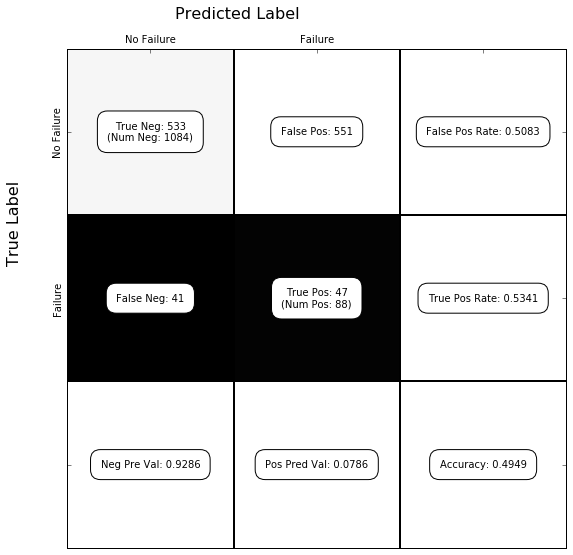

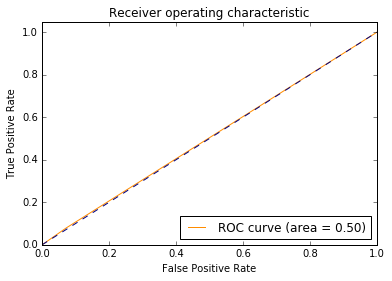

training fold 2 of 10


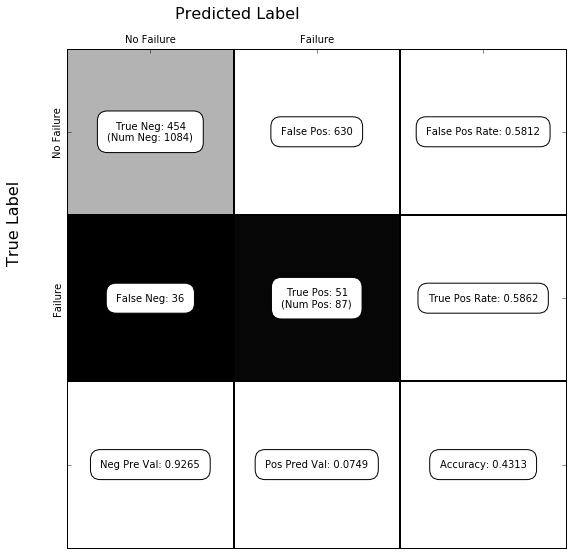

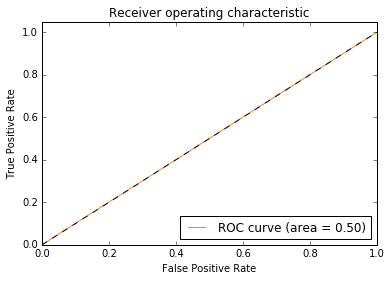

training fold 3 of 10


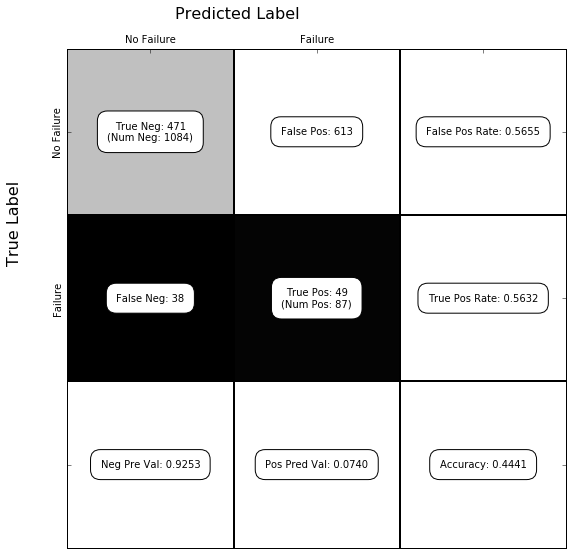

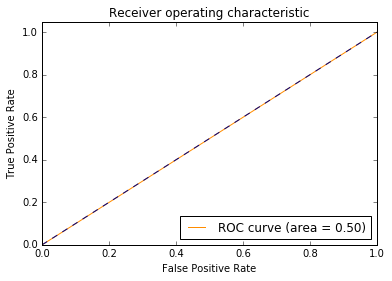

training fold 4 of 10


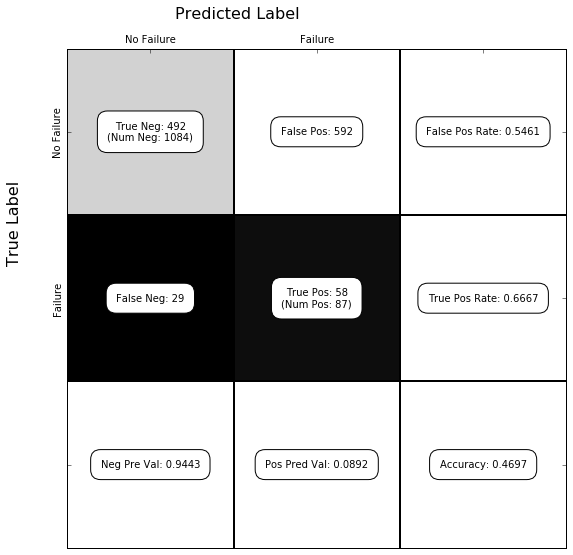

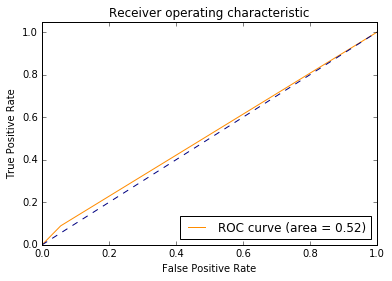

training fold 5 of 10


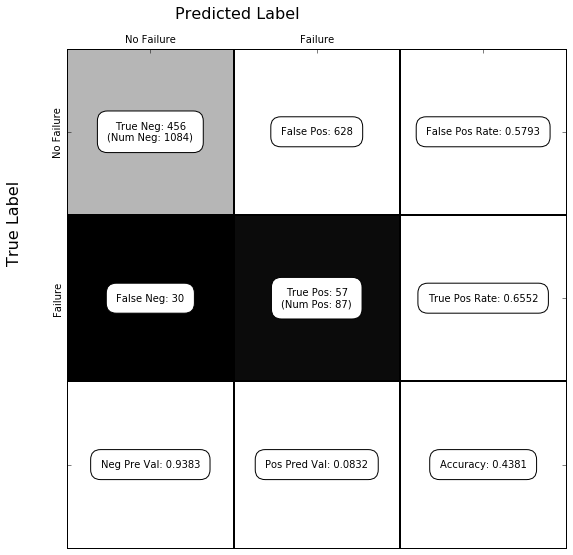

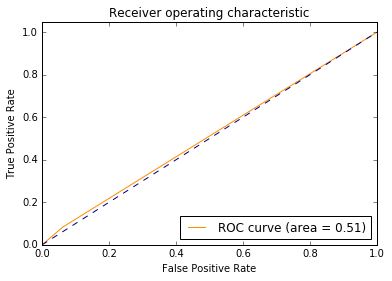

training fold 6 of 10


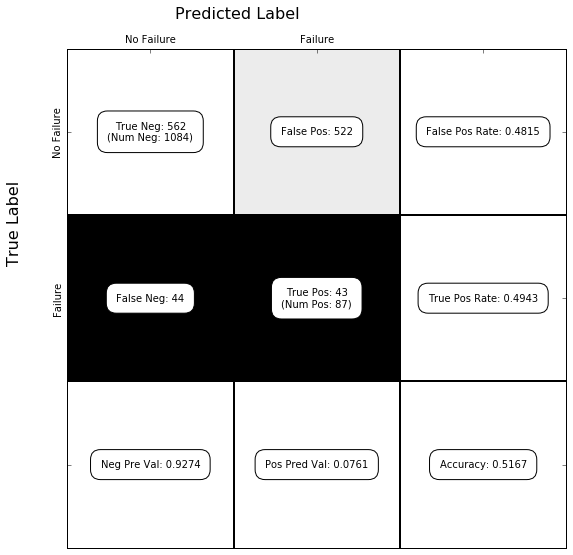

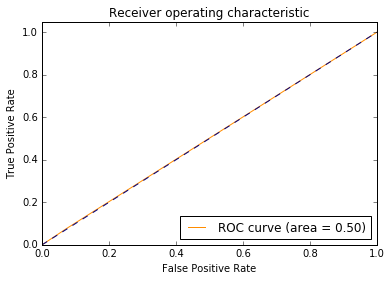

training fold 7 of 10


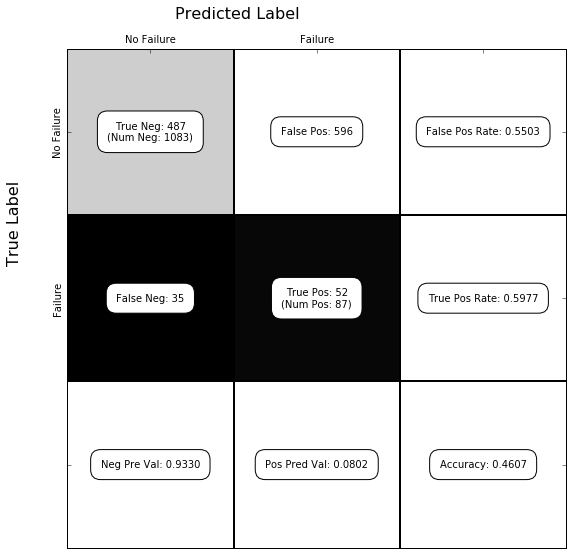

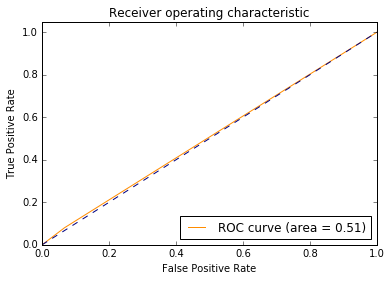

training fold 8 of 10


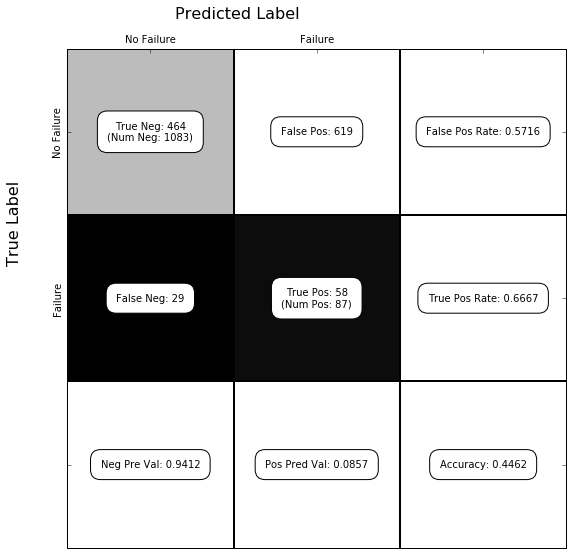

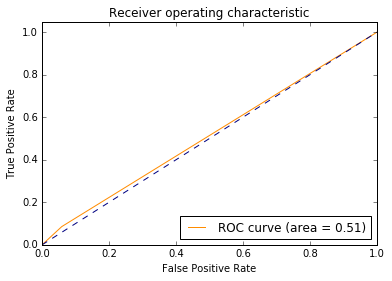

training fold 9 of 10


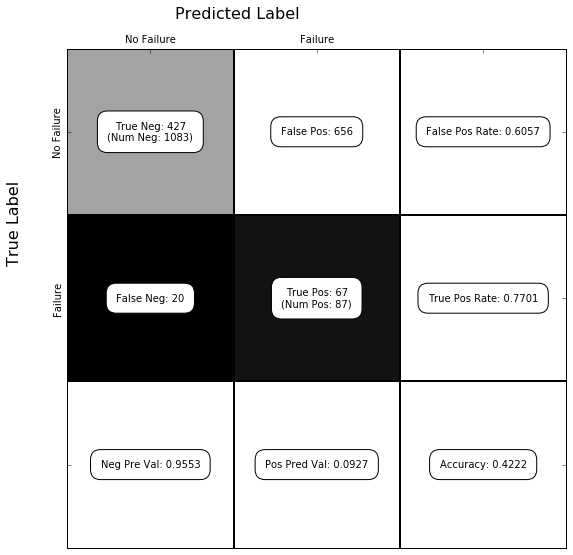

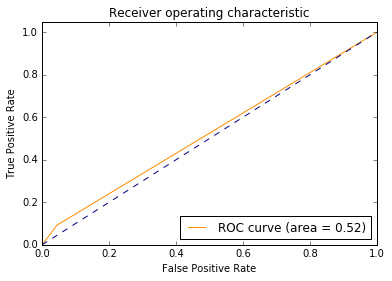

training fold 10 of 10


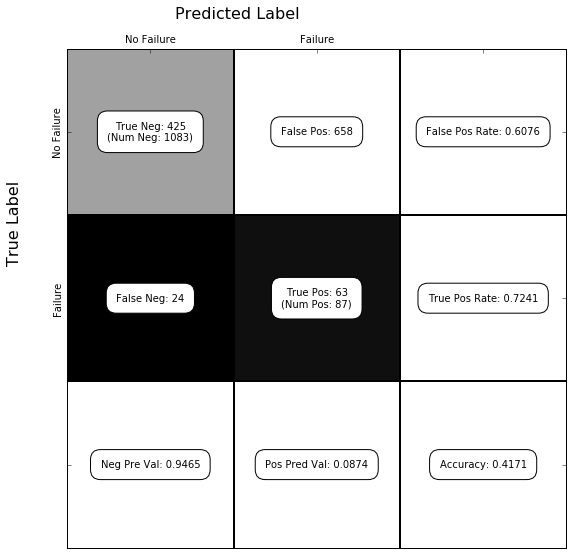

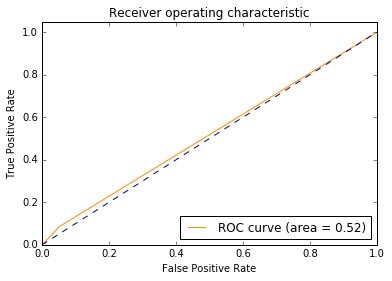

average true positive rate: 0.6258228840125393
Maximum true positive rate: 0.7701149425287356
training full model


In [17]:
training_features=['_136222210_count_2_',
           '_136222202_count_1_', '_136222202_count_2_', '_136222210_count_0_',
           '_136225010_count_2_', '_136225010_count_1_', '_136224578_count_0_',
           '_136225010_count_0_', '_136222202_count_0_', '_136224586_count_1_',
           '_136224586_count_0_', '_136224578_count_1_', '_136110468_count_2_',
           '_136224578_count_2_', '_136224586_count_2_',
           '_136110468_count_0_', '_136110468_count_1_','totalCount']
target='Label'
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
clf =  LogisticRegression(class_weight={1:13,0:1})

#clf = DecisionTreeClassifier(class_weight={1:100,0:1})
DMaxmodel, dtest, dtrain = train_and_calibrate_cv(clf,newtrain[training_features],newtrain[target],10)



We conduct preprocessing again for our testing data to be submitted on Kaggle to make sure it is consistent with the parameters for our machine learning models.

In [18]:
def processVer_Data (data):
    newData = pd.DataFrame()
    for col in data.columns:
        if col not in ['Label','Machine','Date']:
            newData[col+'0_']=data[col]
            newData[col+'1_']=data[col].copy().shift(1)
            newData[col+'2_']=data[col].copy().shift(2)
        
    newData = newData.fillna(0)
    arr=np.sum(newData.values.astype(float), axis=1)
    newData['totalCount'] = arr
    
    newData['Machine']=data['Machine']
    newData['Date']=data['Date']
    return newData
newtest = processVer_Data(verification)
newtest.head()

,_1_count_0_,_1_count_1_,_1_count_2_,_1_vMean_0_,_1_vMean_1_,_1_vMean_2_,_1_vStd_0_,_1_vStd_1_,_1_vStd_2_,_136088194_count_0_,...,_136676754_count_2_,_136676754_vMean_0_,_136676754_vMean_1_,_136676754_vMean_2_,_136676754_vStd_0_,_136676754_vStd_1_,_136676754_vStd_2_,totalCount,Machine,Date
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,200253.634609,M066_A1,21/5/2015
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,332155.581497,M066_A1,22/5/2015
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,429295.826279,M066_A1,23/5/2015
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,373904.677145,M066_A1,24/5/2015
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,317132.527126,M066_A1,25/5/2015


We submit the testing prediction dataset to Kaggle in the mini-contest. It gave an accuracy of 0.50236 shown on Kaggle.

In [19]:
writecsv(DMaxmodel.predict(newtest[training_features]), newtest, 'logistic.csv')

### Dense

We select only these six features (136222210 136222202 136225010 136224578 136224586 136110468) got from our exploration and generate some new ones based on these. 

We use the count of the current date and previous two days, the multiplication of the mean and std of the current date as our new features. 

We get 24 columns and used a simple 3-layer dense neural net for prediction. As more than 90 percentages of the records have a negative label (label 0), in the training, for every batch, we try to balance the number of the records for each label class. (or the neural net just predict all of the label to be 0, which may achieves high accuracy but not really learning the features)

The network is: 24 -> 64 -> 16 -> 2, with a softmax cross entropy loss. We train it with learning rate 1e-4, epoches 5000, batch size 150 and set the number of records with negative label to be about 70% of the batch. 

Our best result (area under curve) got from kaggle is around 0.515. 

In [20]:
def processData (data):
    newData = pd.DataFrame()
    for col in data.columns:
        if col not in ['Label','Machine','Date'] and col.find('count') != -1:
            newData[col+'0_']=data[col]
            newData[col+'1_']=data[col].copy().shift(1)
            newData[col+'2_']=data[col].copy().shift(2)
    newData = newData.fillna(0)
    arr=np.sum(newData.values.astype(float), axis=1)
    newData['totalCount'] = arr

    columns = ['_136222210_count_2_',
           '_136222202_count_1_', '_136222202_count_2_', '_136222210_count_0_',
           '_136225010_count_2_', '_136225010_count_1_', '_136224578_count_0_',
           '_136225010_count_0_', '_136222202_count_0_',
            '_136224578_count_1_',
           '_136224578_count_2_',
           '_136110468_count_0_', '_136110468_count_1_', '_136110468_count_2_',
            '_136224586_count_2_', '_136224586_count_0_', '_136224586_count_1_',
            'totalCount']
    # 136222210 136224578  > 136110468 >? 136224586 > 136222202 136225010
    newData = newData[columns]
    
    newData['_136222210_mts_'] = data['_136222210_vMean_'].values.astype(float) * data['_136222210_vStd_'].values.astype(float)
    newData['_136222202_mts_'] = data['_136222202_vMean_'].values.astype(float) * data['_136222202_vStd_'].values.astype(float)
    newData['_136225010_mts_'] = data['_136225010_vMean_'].values.astype(float) * data['_136225010_vStd_'].values.astype(float)
    newData['_136224578_mts_'] = data['_136224578_vMean_'].values.astype(float) * data['_136224578_vStd_'].values.astype(float)
    newData['_136224586_mts_'] = data['_136224586_vMean_'].values.astype(float) * data['_136224586_vStd_'].values.astype(float)
    newData['_136110468_mts_'] = data['_136110468_vMean_'].values.astype(float) * data['_136110468_vStd_'].values.astype(float)
  
    return newData

In [21]:
X = tf.placeholder(dtype=tf.float32, shape=[None, 24])
y = tf.placeholder(dtype=tf.int32, shape=[None])
logits0 = tf.contrib.layers.fully_connected(X, 64)
logits1 = tf.contrib.layers.fully_connected(logits0, 16)
logits2 = tf.contrib.layers.fully_connected(logits1, 2)
y_ = tf.one_hot(y, 2)
out = tf.argmax(logits2, axis=1)
loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_,logits=logits2))

615
273
0 2595.3232 (0.738602643647154, 0.26139735635284594, -9.826624937865475)
2873
100 1865.6438 (0.07364445643377394, 0.9263555435662261, -0.07949912638322676)
0
200 1579.3617 (0.07418397626112759, 0.9258160237388724, -0.08740754489152858)
10
300 1539.5304 (0.07796061505260318, 0.9220393849473968, -0.14276647444964286)
32
400 1523.8254 (0.08038845427569463, 0.9196115457243054, -0.17835435773700214)
45
500 1521.1421 (0.08173725384407877, 0.9182627461559212, -0.19812540400775713)
54
600 1516.9341 (0.08146749393040194, 0.918532506069598, -0.194171194753606)
53
700 1518.9312 (0.08551389263555435, 0.9144861073644457, -0.2534843335658712)
70
800 1510.9639 (0.08470461289452387, 0.9152953871054761, -0.24162170580341824)
67
900 1518.6566 (0.08362557323981656, 0.9163744267601834, -0.22580486878681416)
67
1000 1504.9546 (0.08146749393040194, 0.918532506069598, -0.194171194753606)
59
1100 1501.3351 (0.0820070137577556, 0.9179929862422445, -0.20207961326190826)
63
1200 1503.8761 (0.083895333153

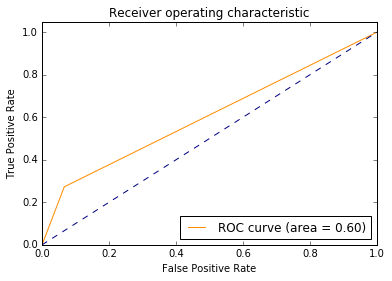

(0.0898300512543836, 0.9101699487456164, -0.31675168163228773)


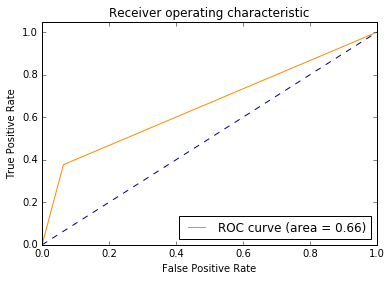

(0.08725, 0.91275, -0.22947526022315068)


In [22]:
def train_model (lr, epochs, batch_size, Logging, 
                 X_train_0, y_train_0, X_train_1, y_train_1, scale_0,
                 X_train, y_train, X_test, y_test, 
                 X_verification, verification_data):
    opt = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
    with tf.Session() as net:
        net.run(tf.global_variables_initializer())
        for e in range(epochs):
            shuffle_indices = np.random.permutation(len(X_train_0))
            X_train_0 = X_train_0[shuffle_indices]
            y_train_0 = y_train_0[shuffle_indices]
            shuffle_indices = np.random.permutation(len(X_train_1))
            X_train_1 = X_train_1[shuffle_indices]
            y_train_1 = y_train_1[shuffle_indices]
            number = np.minimum(len(X_train_0), len(X_train_1)) // batch_size
            for i in range(0, number):
                start = i * batch_size
                first = X_train_0[start:start + int(batch_size * scale_0)]
                second = X_train_1[start:start + int(batch_size * (1.0 - scale_0))]
                batch_x = np.concatenate((first, second))
                first = y_train_0[start:start + int(batch_size * scale_0)]
                second = y_train_1[start:start + int(batch_size * (1.0 - scale_0))]
                batch_y = np.concatenate((first, second))
                net.run(opt, feed_dict={X: batch_x, y: batch_y})
                
            if (e % 100 == 0) and Logging:
                [loss_v, out_v] = net.run([loss, out], feed_dict={X: X_test, y: y_test})
                print(e, loss_v, measureResult(out_v, y_test, False))
                print(np.sum(out_v))
            if e == epochs-1:
                [loss_v, out_v] = net.run([loss, out], feed_dict={X: X_test, y: y_test})
                get_roc_and_area(out_v, y_test)
                print(measureResult(out_v, y_test, False))
                [loss_v, out_v] = net.run([loss, out], feed_dict={X: X_train, y: y_train})
                get_roc_and_area(out_v, y_train)
                print(measureResult(out_v, y_train, False))
                [y_ver] = net.run([out], feed_dict={X: X_verification})
                writecsv(y_ver, verification_data, 'try_submission_0.csv')

train = getData('data/Training freq 1D OW 2 PW 1.csv')
verification = getData('data/Verification freq 1D OW 2 PW 1.csv', 'test')
ptrain = processData(train)
pverification = processData(verification)
                
dataX = ptrain.copy()
datay = train['Label'].copy()
scaler = MinMaxScaler()
scaler.fit(dataX)

train_index = np.random.randint(len(dataX), size=8000)
test_index = np.random.randint(len(dataX), size=len(dataX) - 8000)

trainX = dataX.values[train_index]
trainy = datay.values[train_index]
trainy_0 = trainy[trainy == 0]
trainy_1 = trainy[trainy == 1]
trainX_0 = scaler.transform(trainX[trainy == 0])
trainX_1 = scaler.transform(trainX[trainy == 1])

train_X = scaler.transform(trainX)
train_y = trainy
testX = scaler.transform(dataX.values[test_index])
testy = datay.values[test_index]
verificationX = scaler.transform(pverification)
print(np.sum(trainy))
print(np.sum(testy))
train_model(1e-4, 5000, 150, True,
            trainX_0, trainy_0, trainX_1, trainy_1, 0.7,
            train_X, train_y, testX, testy,
            verificationX, verification)

### LSTM

Here we only use four features (136222210 136224578 136110468 136224586) to generate our new feature. And we use 3 time series. (that is, we use the data of current day and previous two day)

To solve the similar unbalanced class number problem faced when training dense neural net, here we generate more records with label 1 for our model and use the generated data for training. 

We get similar result (area under curve) around 0.515, which is similar to dense neural net. 

In [23]:
def processData (data):
    newData = pd.DataFrame()
    for col in data.columns:
        if col not in ['Label','Machine','Date'] and col.find('count') != -1:
            newData[col]=data[col]
    newData = newData.fillna(0)
    arr=np.sum(newData.values.astype(float), axis=1)
    newData['totalCount'] = arr

    columns = [
            '_136222210_count_', 
            '_136224578_count_',
            '_136110468_count_',
            '_136224586_count_',
            'totalCount'
    ]
    # 136222210 136224578  136110468 136224586
    newData = newData[columns]
    
    newData['_136222210_mts_'] = data['_136222210_vMean_'].values.astype(float) * data['_136222210_vStd_'].values.astype(float)
    newData['_136224578_mts_'] = data['_136224578_vMean_'].values.astype(float) * data['_136224578_vStd_'].values.astype(float)
    newData['_136224586_mts_'] = data['_136224586_vMean_'].values.astype(float) * data['_136224586_vStd_'].values.astype(float)
    newData['_136110468_mts_'] = data['_136110468_vMean_'].values.astype(float) * data['_136110468_vStd_'].values.astype(float)
  
    newData.insert(0, 'Machine', data['Machine'].copy(), True)
    newData.insert(1, 'Date', data['Date'].copy(), True)

    return newData

In [24]:
def create_training_dataset(dataset, look_back=3, mode='train', positive_weight=1):
    machines = np.unique(dataset['Machine'])
    dataX, dataY = list(), list()
    for mach in machines:
        mach_df = dataset[dataset['Machine'].str.contains(mach, case=True)].values
        mach_df = np.delete(mach_df, [0,1], axis=1)
        
        for i in range(look_back-1):
            oneInput = list()
            for j in range(look_back-1-i):
                oneInput.append(np.zeros_like(mach_df[0]))
            for k in range(i+1):
                oneInput.append(mach_df[k])
            oneInput_np = np.array(oneInput)
            if mode == 'train':
                dataX.append(oneInput_np[:,:-1])
                dataY.append(oneInput_np[-1,-1])
            else:
                dataX.append(oneInput_np)

        for i in range(len(mach_df)-look_back+1):
            if mode == 'train':
                oneInput = mach_df[i:(i+look_back),:-1]
                repeat = 1
                if mach_df[i+look_back-1,-1] == 1:
                    repeat = positive_weight
                for r in range(repeat):
                    dataX.append(oneInput)
                    dataY.append(mach_df[i+look_back-1,-1])
            else:
                oneInput = mach_df[i:(i+look_back),:]
                dataX.append(oneInput)
                
    return np.array(dataX), np.array(dataY)

In [25]:
train = getData('data/Training freq 1D OW 2 PW 1.csv')
ptrain = processData(train)
                
dataX = ptrain.copy()
datay = train['Label'].copy()
dataX['Label'] = train['Label'].copy()

In [26]:
xxx, yyy = create_training_dataset(dataX,3,'train',7)
xxx = xxx.astype(float)

In [27]:
def trainLSTM(X, y, ep=1000, valid_split=0.3, b_size=3, seed=0):
    print(X.shape, X.shape[-2:])
    if seed == 0:
        seed = int(time.time())
    np.random.seed(seed)
    model = Sequential()
    model.add(LSTM(24, input_shape=X.shape[-2:], return_sequences=True))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(lr=4e-4)
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    model.fit(X, y, epochs=ep, validation_split=valid_split, batch_size=b_size)
    return model

In [28]:
def saveModel(model, modelFilenamePrefix):
    structureFilename = modelFilenamePrefix + ".json"
    model_json = model.to_json()
    with open(structureFilename, "w") as f:
        f.write(model_json)
    weightFilename = modelFilenamePrefix + ".h5"
    model.save_weights(weightFilename)

In [29]:
train_index = np.random.randint(len(xxx), size=int(len(xxx) * 0.8))
test_index = np.random.randint(len(xxx), size=int(len(xxx) * 0.2))

train_x = xxx[train_index]
train_y = yyy[train_index]

test_x = xxx[test_index]
test_y = yyy[test_index]

In [30]:
m = trainLSTM(xxx, yyy, ep=3, valid_split=0.25, b_size=8)

(16927, 3, 9) (3, 9)
Train on 12695 samples, validate on 4232 samples
Epoch 1/3
12695/12695 [==============================] - 10s 800us/step - loss: 0.6679 - acc: 0.6122 - val_loss: 0.6780 - val_acc: 0.6092
Epoch 2/3
12695/12695 [==============================] - 9s 708us/step - loss: 0.6452 - acc: 0.6465 - val_loss: 0.6769 - val_acc: 0.6129
Epoch 3/3
12695/12695 [==============================] - 9s 692us/step - loss: 0.6406 - acc: 0.6492 - val_loss: 0.6755 - val_acc: 0.6146


In [31]:
saveModel(m,'istm2')

353
mse  0.35809762942175616
accuracy 0.6419023705782438
R2 -0.5502064555524895


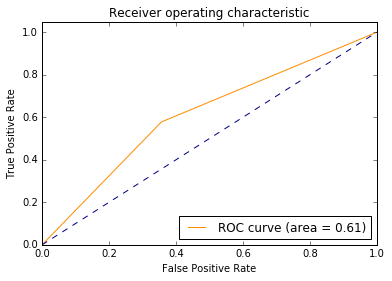

89
mse  0.36307237813884785
accuracy 0.6369276218611521
R2 -0.5537497665732964


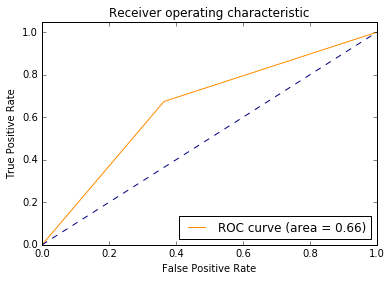

423
mse  0.35670821764045607
accuracy 0.6432917823595439
R2 -0.5485153224574326


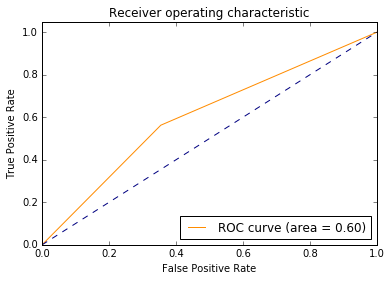

In [32]:
y_pred = m.predict(train_x) > 0.5
y_pred = [1 if v else 0 for v in y_pred]
print(np.sum(y_pred))
measureResult(y_pred, train_y, True)
get_roc_and_area(y_pred, train_y)

y_pred = m.predict(test_x) > 0.5
y_pred = [1 if v else 0 for v in y_pred]
print(np.sum(y_pred))
measureResult(y_pred, test_y, True)
get_roc_and_area(y_pred, test_y)

y_pred = m.predict(xxx) > 0.5
y_pred = [1 if v else 0 for v in y_pred]
print(np.sum(y_pred))
measureResult(y_pred, yyy, True)
get_roc_and_area(y_pred, yyy)

In [33]:
verification = getData('data/Verification freq 1D OW 2 PW 1.csv', 'test')
pverification = processData(verification)
ver_data_X, yyy = create_training_dataset(pverification, 3, 'test')
y_pred = m.predict(ver_data_X) > 0.5
y_pred = [1 if v else 0 for v in y_pred]
print(np.sum(y_pred))
writecsv(y_pred, verification, 'report-lstm.csv')

110


#### Final Conclusion

Dense neural net and LSTM neural net are the best among all of the models we have tried. Here we didn't get a higher area under curve value when using LSTM, but we may still assume that LSTM can be better as its structure is quite compatible with time-series things. In possible future work, we will try more tuning on training LSTM (tune the network structure or training parameters like learning rate) and try to get a better result. 

From our exploration of the dataset and other helpful analytic tools like random forest and logistic regression, We may assume that 136222210 and 136224578 are the most important two features. However, here we didn't find or construct a feature which significantly improves our prediction result. With more time, we will work more on feature engineering as this may greatly improves our result with good features. 

The biggest problem we faced in training is that the number of the records with negative label is just too large. Over 90% of the records have a negative label. Here the method we tried is to balance the class number ratio in our training batch. We may explore other methods to solve this kind of problem, like trying out droping some of the records with negative label with certain standard. 

Our final result is around 0.515 with dense neural network and lstm neural network.